In [250]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import pickle
from scipy.spatial import KDTree
from tqdm import tqdm
# import spatialdata_io
import spatialdata
import sys
sys.path.append('/Users/bzhao2/Library/CloudStorage/OneDrive-InsideMDAnderson/Projects-AkdemirLab/pipelines/PyUtils')
import xenium_pyutils
import random
random.seed(42)
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
plot_dir  = '/Users/bzhao2/Library/CloudStorage/OneDrive-InsideMDAnderson/akdemirlab-projects/01_catalyst/scripts/figures/Fig6/Fig6.5/plots'
data_dir = '/Users/bzhao2/Library/CloudStorage/OneDrive-InsideMDAnderson/akdemirlab-projects/01_catalyst/scripts/figures/Fig6/Fig6.5/data/2'

In [ ]:
## load data

## filter cells and transcripts

def filter_transcripts(spdata):

    bdata = spdata.tables['table']
    adata = bdata.copy()
    adata.obs = adata.obs.set_index('cell_id') ## filter only for str/categorical index
    adata = adata[(adata.obs['total_counts'] > 20) & 
                  (adata.obs['total_counts'] < 800)]
    adata = adata[(np.sum(adata.X > 0, axis=1) > 4)]

    transcripts = spdata.points['transcripts']
    filtered_transcripts = transcripts[
        # (~transcripts['feature_name'].str.startswith('BLANK')) & 
        # (~transcripts['feature_name'].str.startswith('DeprecatedCodeword')) &
        # (~transcripts['feature_name'].str.startswith('NegControlCodeword')) &
        # (~transcripts['feature_name'].str.startswith('NegControlProbe')) &
        # (~transcripts['feature_name'].str.startswith('UnassignedCodeword')) &
        (transcripts['qv'] >= 20) &
        (transcripts['cell_id'].isin(adata.obs_names))
    ].compute()

    nb = spdata.shapes['nucleus_boundaries']
    filtered_nb = nb[nb.index.isin(adata.obs_names)]
    
    return filtered_transcripts, filtered_nb, adata

p59p_hb_spdata = spatialdata.read_zarr(f'{data_dir}/p59P_hBreast.zarr')
p59p_hb_transcripts, p59p_hb_nb, p59p_hb_adata = filter_transcripts(p59p_hb_spdata)

p68p_hb_spdata = spatialdata.read_zarr(f'{data_dir}/p68P_hBreast.zarr')
p68p_hb_transcripts, p68p_hb_nb, p68p_hb_adata = filter_transcripts(p68p_hb_spdata)

# p68p_hb_adata = sc.read_h5ad(f'{data_dir}/p68p_hb_filtered_adata.h5ad')
# p68p_hb_transcripts = pd.read_parquet(f'{data_dir}/p68p_hb_filtered_transcripts.parquet')

# import dask
# dask.config.set({'dataframe.query-planning': False})
# with open(f'{data_dir}/p68p_hb_filtered_nucleus_boundaries.pkl', 'rb') as f:
#     p68p_hb_nb = pickle.load(f)

# p59p_hb_adata = sc.read_h5ad(f'{data_dir}/')
# p59p_hb_transcripts = pd.read_parquet(f'{data_dir}/p59p_hb_filtered_transcripts.parquet')
# with open(f'{data_dir}/p59p_hb_filtered_nucleus_boundaries.pkl', 'rb') as f:
#     p59p_hb_nb = pickle.load(f)


/Users/bzhao2/miniforge3/envs/single-cell/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/bzhao2/miniforge3/envs/single-cell/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
## human breast panel: EGFR and MDM2
## human immuno-oncology panel: EGFR, CDK4 and CDK6

### analysis
# 1, frequency distribution of EGFR and MDM2
# 2, transcript counts correlation between EGFR and MDM2
# 3, ripley's K function
# 4, spatial clustering
# 5, transcripts inside and outside of nucleus

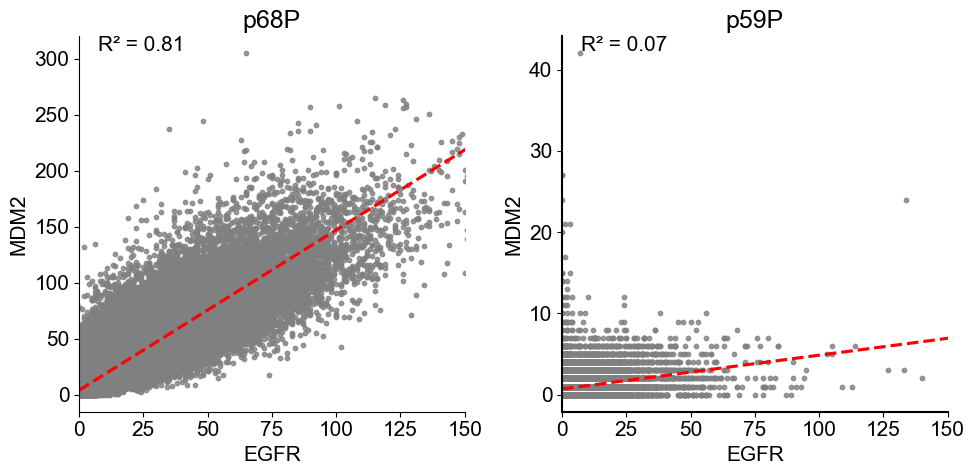

In [419]:
import seaborn as sns
from scipy.stats import linregress
import matplotlib.pyplot as plt

df1 = p68p_hb_adata[:, ['EGFR', 'MDM2']].to_df()
df1['sample'] = 'p68P'
df2 = p59p_hb_adata[:, ['EGFR', 'MDM2']].to_df()
df2['sample'] = 'p59P'
df = pd.concat([df1, df2])


# Create subplots
plt.rcParams.update({'font.family': 'Arial', 'font.size': 15})
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# Scatter plot with regression line for p68P sample
sns.regplot(x=df[df['sample'] == 'p68P']['EGFR'], 
            y=df[df['sample'] == 'p68P']['MDM2'], 
            data=df[df['sample'] == 'p68P'], 
            ci=None,
            ax=axes[0], scatter_kws={'s': 10, 'color': 'gray'}, 
            line_kws={'color': 'red', 'linestyle': '--'})
axes[0].set_title('p68P')
axes[0].set_xlabel('EGFR')
axes[0].set_ylabel('MDM2')
axes[0].set_xlim(0, 150)

# Calculate and display R2 for p68P sample
slope, intercept, r_value, p_value, std_err = linregress(
    df[df['sample'] == 'p68P']['EGFR'], 
    df[df['sample'] == 'p68P']['MDM2']
)
axes[0].annotate(f'R² = {r_value**2:.2f}', 
                 xy=(0.05, 1), xycoords='axes fraction', verticalalignment='top')

# Scatter plot with regression line for p59P sample
sns.regplot(x=df[df['sample'] == 'p59P']['EGFR'], 
            y=df[df['sample'] == 'p59P']['MDM2'], 
            data=df[df['sample'] == 'p59P'], 
            ci=None, 
            ax=axes[1], scatter_kws={'s': 10, 'color': 'gray'}, 
            line_kws={'color': 'red', 'linestyle': '--'})
axes[1].set_title('p59P')
axes[1].set_xlabel('EGFR')
axes[1].set_ylabel('MDM2')
axes[1].set_xlim(0, 150)
# axes[1].set_aspect('equal')

# Calculate and display R2 for p59P sample
slope, intercept, r_value, p_value, std_err = linregress(
    df[df['sample'] == 'p59P']['EGFR'], 
    df[df['sample'] == 'p59P']['MDM2']
)
axes[1].annotate(f'R² = {r_value**2:.2f}', 
                 xy=(0.05, 1), xycoords='axes fraction', verticalalignment='top')

# Remove top and right spines
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Save the plot
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.savefig(f"{plot_dir}/scatter_plot_egfr_mdm2.png", dpi=300, bbox_inches='tight')
# Adjust layout
plt.tight_layout()


## log2
#  xlimit to 100
# dots gray
# R2 only
#  title with sample name
#  dash line with regression line

